In [1]:
import exmel
from pathlib import Path

piano = exmel.PianoMidi(Path("mid_files/anhao_transcription.mid"))
melody = exmel.Melody(Path("mid_files/anhao_melody.mid"))
ground_truth = exmel.Melody(Path("mid_files/anhao_rectified.mid"), 3)
baseline = exmel.Melody(Path("mid_files/anhao_baseline.mid"), 3)

c:\Users\Administrator\miniconda3\envs\exmel\Lib\site-packages\pretty_midi\instrument.py:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
m = (melody ^ 12)[:389]
m_1 = piano.match_chunk(m, "l2r", local_tolerance=0.2)
print(m_1[0].sum_miss)
part_1 = m_1[0].events

m = (melody ^ 12)[389:512]
m_2 = piano.match_chunk(m, "l2r", local_tolerance=0.15)
print(m_2[0].sum_miss)
part_2 = m_2[0].events

extracted_mel = exmel.Melody(part_1 + part_2)

18
29


In [3]:
ground_truth = ground_truth % 12
extracted_mel = extracted_mel % 12
baseline = baseline % 12

Evaluation plot saved to: melody_evaluation_result.png


EvaluationResult(tp=438, fp=27, fn=91, precision=0.9419354838709677, recall=0.8279773156899811, f1_score=0.881287726358149, plot=<Figure size 3000x700 with 1 Axes>)

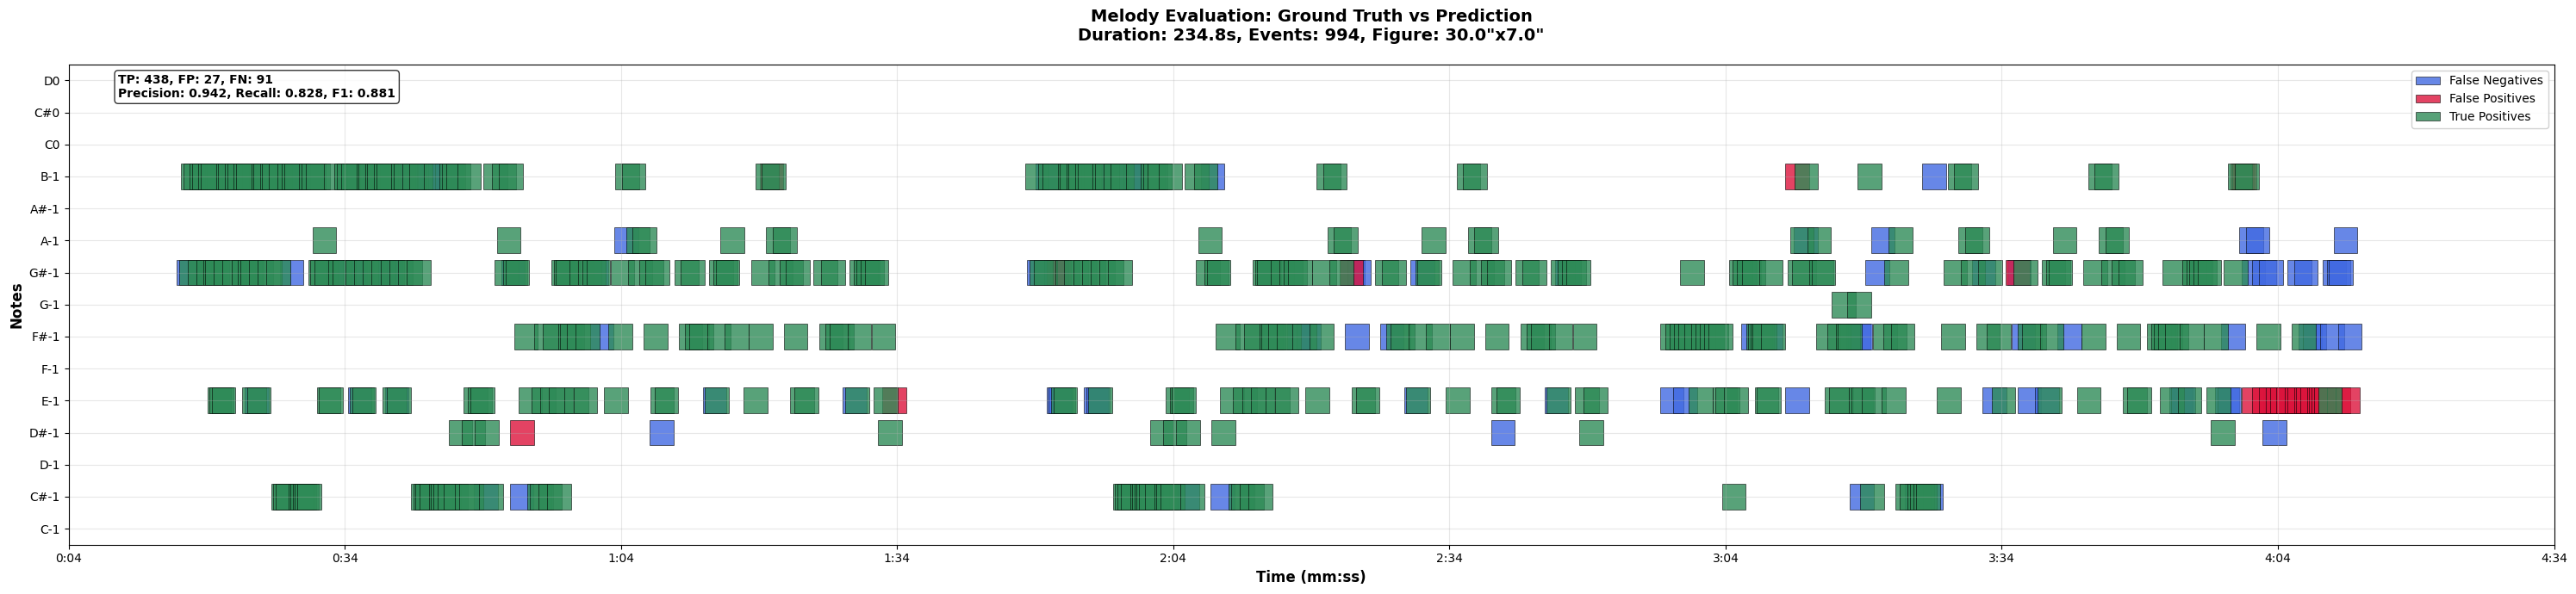

In [4]:
exmel.evaluate_melody(ground_truth, extracted_mel, save_path="melody_evaluation_result.png")

Evaluation plot saved to: baseline_result.png


EvaluationResult(tp=480, fp=210, fn=49, precision=0.6956521739130435, recall=0.9073724007561437, f1_score=0.7875307629204266, plot=<Figure size 3000x730 with 1 Axes>)

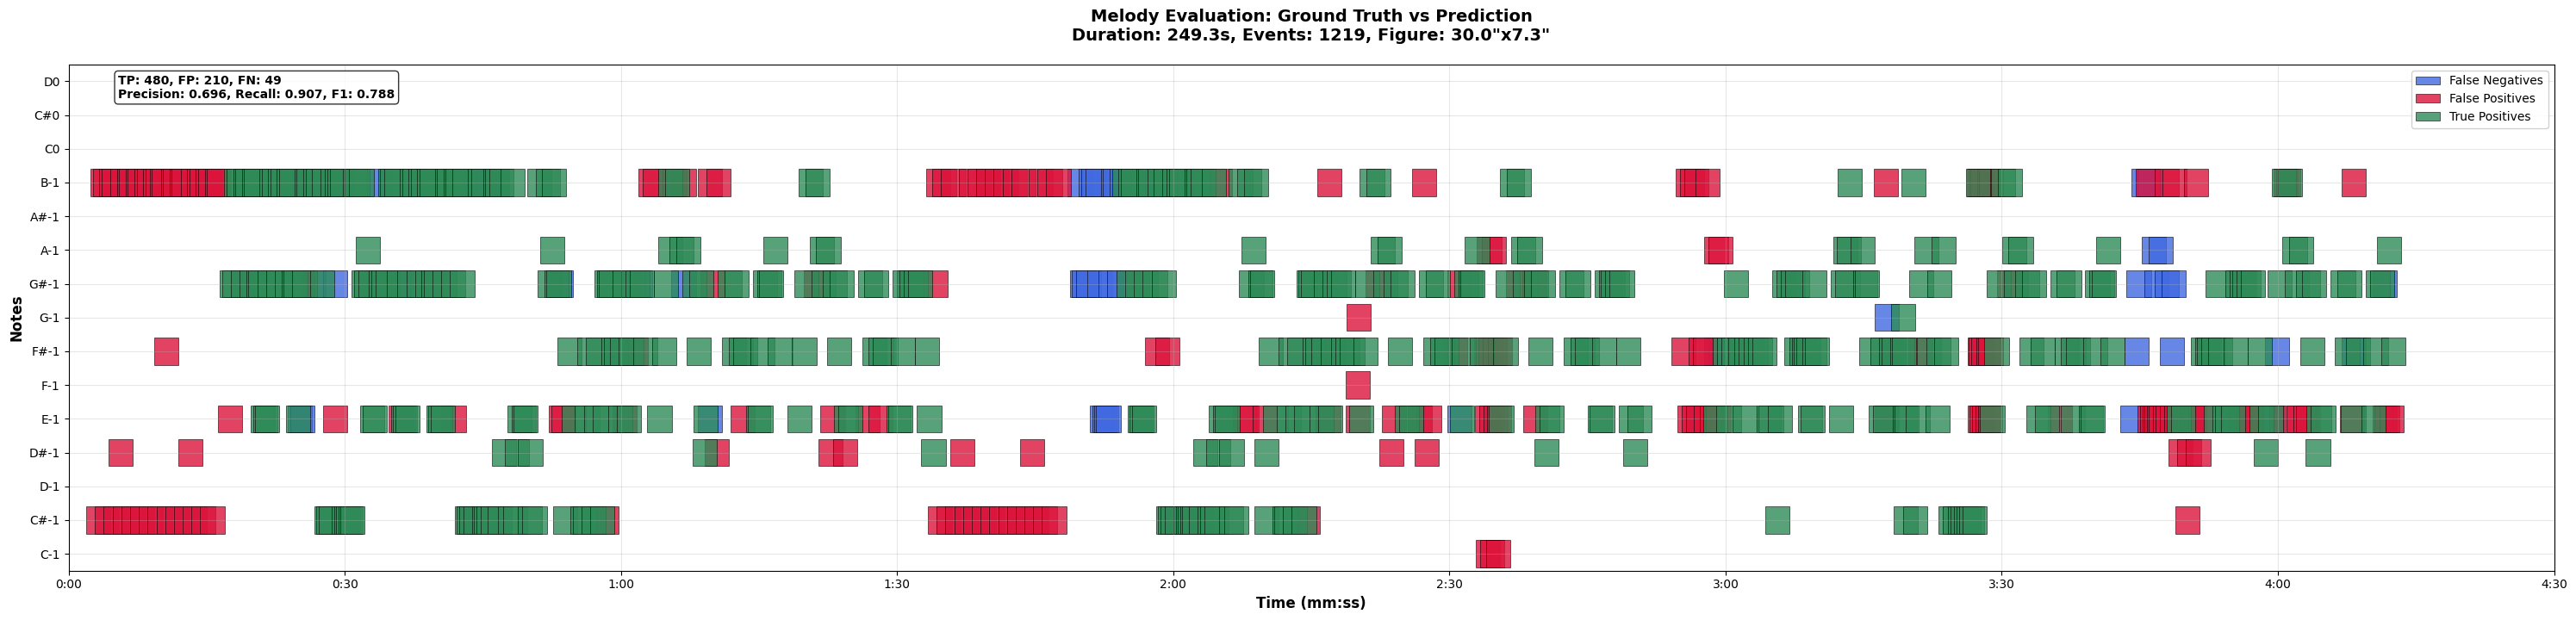

In [5]:
exmel.evaluate_melody(ground_truth, baseline, save_path="baseline_result.png")

In [17]:
tolerance = 0.125
ok = 0
for e in extracted_mel:
    for g in ground_truth:
        if e.note == g.note:
            if abs(e.time - g.time) < tolerance:
                ok += 1
print(ok / len(extracted_mel))

0.9440860215053763


In [16]:
tolerance = 0.125
ok = 0
for b in baseline:
    for g in ground_truth:
        if b.note == g.note:
            if abs(b.time - g.time) < tolerance:
                ok += 1
print(ok / len(baseline))

0.6956521739130435


In [25]:
extracted_mel[80:120]

Melody([MelEvent_(time=41.0000, note='B-1'),
MelEvent_(time=41.5000, note='G#-1'),
MelEvent_(time=41.7000, note='B-1'),
MelEvent_(time=42.0000, note='C#-1'),
MelEvent_(time=42.2000, note='C#-1'),
MelEvent_(time=42.4000, note='C#-1'),
MelEvent_(time=42.6000, note='C#-1'),
MelEvent_(time=42.9000, note='C#-1'),
MelEvent_(time=43.4000, note='B-1'),
MelEvent_(time=43.8000, note='C#-1'),
MelEvent_(time=44.1000, note='C#-1'),
MelEvent_(time=44.3000, note='C#-1'),
MelEvent_(time=44.8000, note='C#-1'),
MelEvent_(time=45.0000, note='B-1'),
MelEvent_(time=45.3000, note='B-1'),
MelEvent_(time=45.5000, note='C#-1'),
MelEvent_(time=45.7000, note='B-1'),
MelEvent_(time=46.0000, note='D#-1'),
MelEvent_(time=46.7000, note='C#-1'),
MelEvent_(time=46.9000, note='B-1'),
MelEvent_(time=47.2000, note='C#-1'),
MelEvent_(time=47.4000, note='D#-1'),
MelEvent_(time=47.6000, note='E-1'),
MelEvent_(time=48.1000, note='E-1'),
MelEvent_(time=48.4000, note='E-1'),
MelEvent_(time=48.8000, note='D#-1'),
MelEvent_(time

In [17]:
len(gt), len(extracted_mel)

(529, 465)

In [27]:
pred - gt

{MelEvent_(time=109.1000, note='G#-1'),
 MelEvent_(time=109.6000, note='G#-1'),
 MelEvent_(time=111.0000, note='G#-1'),
 MelEvent_(time=111.5000, note='E-1'),
 MelEvent_(time=111.7000, note='E-1'),
 MelEvent_(time=112.2000, note='B-1'),
 MelEvent_(time=112.9000, note='G#-1'),
 MelEvent_(time=123.9000, note='E-1'),
 MelEvent_(time=135.7000, note='E-1'),
 MelEvent_(time=142.8000, note='G#-1'),
 MelEvent_(time=146.6000, note='G#-1'),
 MelEvent_(time=161.8000, note='G#-1'),
 MelEvent_(time=166.5000, note='G#-1'),
 MelEvent_(time=181.5000, note='F#-1'),
 MelEvent_(time=185.1000, note='G#-1'),
 MelEvent_(time=186.5000, note='G#-1'),
 MelEvent_(time=191.2000, note='B-1'),
 MelEvent_(time=196.3000, note='G-1'),
 MelEvent_(time=215.2000, note='G#-1'),
 MelEvent_(time=219.0000, note='G#-1'),
 MelEvent_(time=225.3000, note='A-1'),
 MelEvent_(time=226.0000, note='A-1'),
 MelEvent_(time=228.4000, note='E-1'),
 MelEvent_(time=239.6000, note='B-1'),
 MelEvent_(time=239.8000, note='B-1'),
 MelEvent_(t

In [20]:
gt - pred

{MelEvent_(time=108.8000, note='G#-1'),
 MelEvent_(time=109.0000, note='G#-1'),
 MelEvent_(time=109.5000, note='G#-1'),
 MelEvent_(time=109.8000, note='B-1'),
 MelEvent_(time=110.7000, note='G#-1'),
 MelEvent_(time=111.0000, note='E-1'),
 MelEvent_(time=111.2000, note='E-1'),
 MelEvent_(time=111.4000, note='E-1'),
 MelEvent_(time=111.6000, note='E-1'),
 MelEvent_(time=112.1000, note='B-1'),
 MelEvent_(time=112.8000, note='G#-1'),
 MelEvent_(time=115.0000, note='E-1'),
 MelEvent_(time=115.3000, note='E-1'),
 MelEvent_(time=116.9000, note='B-1'),
 MelEvent_(time=118.8000, note='B-1'),
 MelEvent_(time=119.3000, note='B-1'),
 MelEvent_(time=123.8000, note='E-1'),
 MelEvent_(time=125.0000, note='C#-1'),
 MelEvent_(time=127.7000, note='B-1'),
 MelEvent_(time=128.8000, note='C#-1'),
 MelEvent_(time=135.8000, note='E-1'),
 MelEvent_(time=137.1000, note='F#-1'),
 MelEvent_(time=138.1000, note='F#-1'),
 MelEvent_(time=142.9000, note='G#-1'),
 MelEvent_(time=143.3000, note='F#-1'),
 MelEvent_(tim

In [3]:
exmel.extract_original_events(
    extracted_mel,
    Path("mid_files/anhao_transcription.mid"),
    Path("output.mid"))

In [8]:
melody[0].note

52

In [13]:
piano.events_by_note[68]

[(1.45703125, 71),
 (2.41015625, 53),
 (3.36328125, 62),
 (4.311197916666667, 57),
 (5.260416666666667, 60),
 (6.217447916666667, 62),
 (7.174479166666667, 59),
 (8.123697916666666, 67),
 (8.602864583333334, 64),
 (9.075520833333334, 73),
 (10.029947916666666, 73),
 (10.98046875, 68),
 (11.930989583333334, 68),
 (12.885416666666666, 64),
 (13.8359375, 59),
 (14.795572916666666, 55),
 (16.45703125, 69),
 (16.696614583333332, 81),
 (17.645833333333332, 69),
 (18.602864583333332, 71),
 (19.313802083333332, 63),
 (19.555989583333332, 71),
 (20.50390625, 80),
 (21.454427083333332, 76),
 (22.412760416666668, 76),
 (23.118489583333332, 55),
 (23.36328125, 80),
 (24.084635416666668, 53),
 (24.315104166666668, 79),
 (25.270833333333332, 68),
 (26.21484375, 73),
 (26.45703125, 54),
 (31.69140625, 65),
 (31.93359375, 74),
 (32.38671875, 65),
 (32.65234375, 67),
 (32.885416666666664, 71),
 (33.3671875, 71),
 (34.555989583333336, 55),
 (34.795572916666664, 70),
 (35.744791666666664, 72),
 (36.69531

In [6]:
exmel.Melody(piano.match_chunk(m, "l2r")[0].events)

Melody([MelEvent_(time=198.1, note='E5'), ...(89 events)..., MelEvent_(time=251.0, note='E4')])

In [7]:
test = {exmel.MidiEvent(time=16.0, note=60, velocity=100): 2}
test[exmel.MidiEvent(time=8+8, note=60, velocity=100)] = 1
test

{MidiEvent_(time=16.0, note='C4', velocity=100): 1}

In [8]:
t = (0, 1, 2, 3)
t[1:0:-1]

(1,)

In [9]:
exmel.MelEvent_(time=16.0, note='B3')

MelEvent_(time=16.0, note='B3')

In [10]:
piano.nearest(exmel.MelEvent_(time=16.5, note='B3'))

MidiEvent_(time=16.5, note='B3', velocity=49)

In [11]:
piano.right_nearest(exmel.MelEvent(0, 56))

MidiEvent_(time=21.2, note='G#3', velocity=59)

# 1

In [12]:
import pretty_midi
import mido
import matplotlib.pyplot as plt

In [13]:
melody = mido.MidiFile("mid_files/anhao_melody.mid")
piano = mido.MidiFile("mid_files/anhao_transcription.mid")

In [14]:
piano

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=61),
    Message('note_on', channel=0, note=64, velocity=71, time=686),
    Message('note_on', channel=0, note=66, velocity=56, time=191),
    Message('note_on', channel=0, note=68, velocity=71, time=181),
    Message('note_on', channel=0, note=71, velocity=72, time=178),
    Message('control_change', channel=0, control=64, value=0, time=145),
    Message('note_on', channel=0, note=68, velocity=0, time=11),
    Message('note_on', channel=0, note=66, velocity=0, time=0),
    Message('note_on', channel=0, note=71, velocity=0, time=2),
    Message('note_on', channel=0, note=64, velocity=0, time=27),
    Message('note_on', channel=0, n

In [15]:
melody

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=52, velocity=77, time=15360),
    Message('note_on', channel=0, note=52, velocity=0, time=230),
    Message('note_on', channel=0, note=56, velocity=77, time=0),
    Message('note_on', channel=0, note=56, velocity=0, time=231),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=230),
    Message('note_on', channel=0, note=59, velocity=77, time=0),
    Message('note_on', channel=0, note=59, velocity=0, time=231),
    Message('note_on', channel=0, note=56, velocity=77, time=230),
    Message('note_on', channel=0, note=56, velocity=

In [16]:
pretty_midi.PrettyMIDI("mid_files/anhao_transcription.mid").estimate_tempo()

np.float64(241.46507482037745)

In [17]:
pretty_midi.PrettyMIDI("mid_files/anhao_melody.mid").estimate_tempi()

(array([164.07394489, 170.43437093, 149.51330305, 160.92596288,
        132.36307928, 131.90839695, 169.03888481, 168.2570594 ,
        168.51960211, 157.0766294 , 191.04477612, 169.51147734,
        175.37212449, 190.0990099 , 226.87089716, 201.66301969,
        168.97689769, 179.59910913, 117.31160896, 168.17518248,
        152.58278146, 147.56618275, 168.2570594 , 169.74459725,
        168.33901607, 169.82800983, 157.89473684, 140.1459854 ,
        162.98811545, 137.60152891, 105.61056106, 168.91495601,
        144.63276836, 166.83562636, 171.42857143, 169.16299559,
        168.91495601, 142.83942963, 169.03888481, 146.28571429,
        144.63276836, 142.83942963, 113.16306483, 142.9280397 ,
        171.42857143, 166.71490593, 169.03888481, 144.54203262,
        168.91495601, 166.71490593, 169.16299559, 171.30111524,
        166.71490593, 166.59436009, 168.91495601, 187.62214984,
        191.36212625, 191.57427938, 187.4186551 , 150.        ,
        152.51544572, 155.11669659, 150.

In [18]:
import vis

ModuleNotFoundError: No module named 'vis'

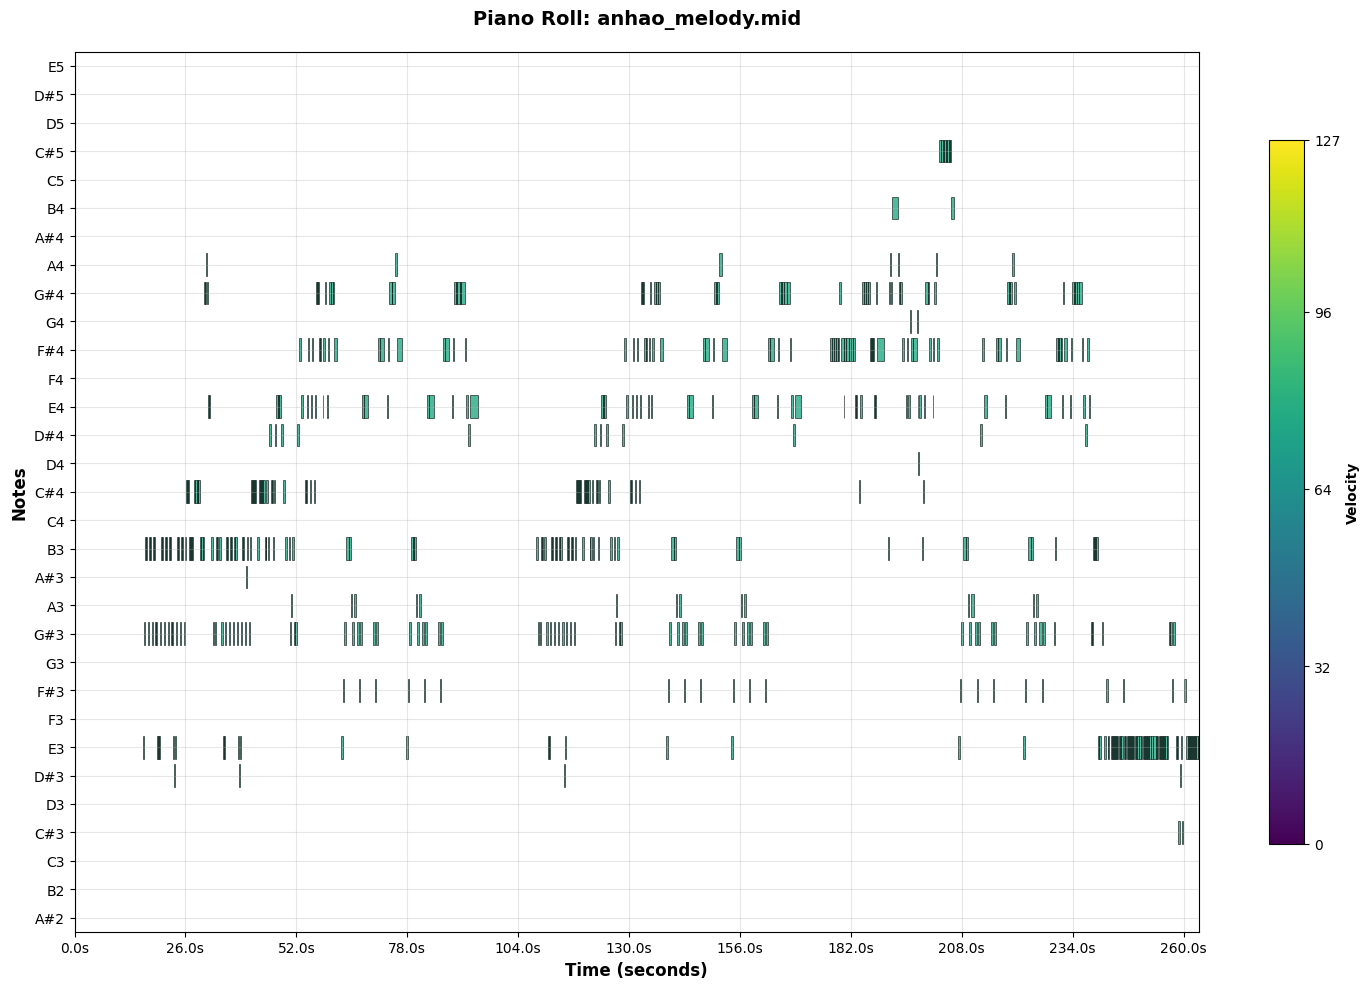

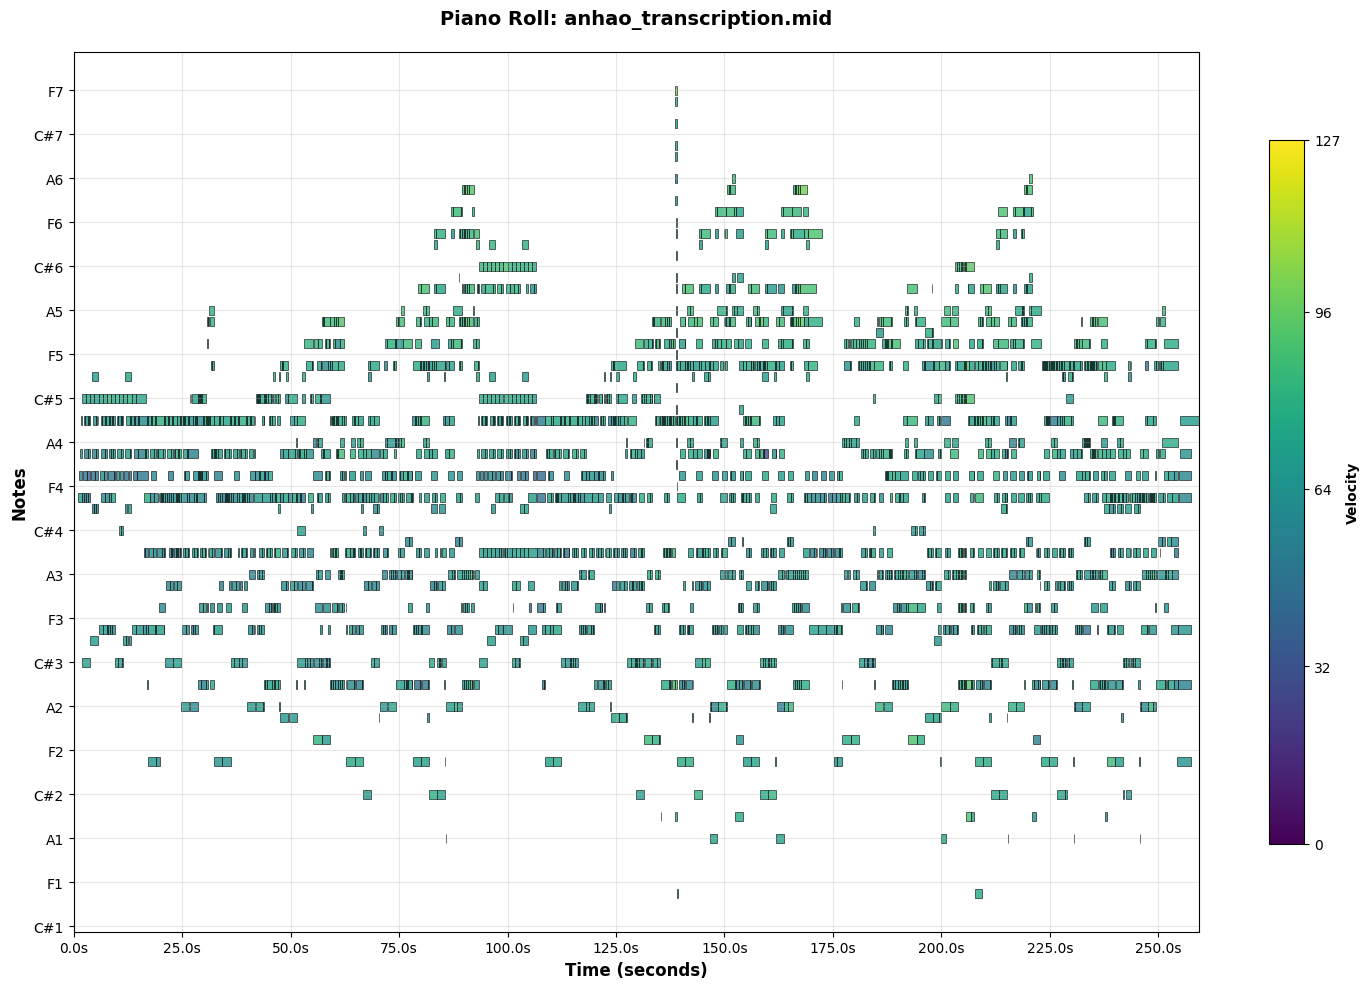

In [ ]:
vis.display_midi_piano_roll("mid_files/anhao_melody.mid")
vis.display_midi_piano_roll("mid_files/anhao_transcription.mid")